In [1]:
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 5.8 MB/s eta 0:00:00


# **1 - Downloading and preparing the dataset**

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf

# ==========================================
# I. PRÉPARATION DES DONNÉES (15 ANS)
# ==========================================

def get_data(tickers, period="15y"):
    # Téléchargement des prix de clôture
    data = yf.download(tickers, period=period)['Close']

    # Conversion en format mensuel (Dernier jour ouvré du mois)
    prices_m = data.resample('BM').last().dropna()
    return prices_m

def calculate_monthly_features(prices_df):
    features_list = []
    for asset in prices_df.columns:
        asset_prices = prices_df[asset]
        df = pd.DataFrame(index=asset_prices.index)

        # Rendements log mensuels
        df[f'{asset}_Ret'] = np.log(asset_prices / asset_prices.shift(1))

        # RSI Mensuel (fenêtre de 6 mois pour la réactivité)
        delta = asset_prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=6).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=6).mean()
        rs = gain / loss
        df[f'{asset}_RSI'] = 100 - (100 / (1 + rs))

        # Tendance : Moyenne 3 mois vs 12 mois
        df[f'{asset}_Trend'] = asset_prices.rolling(window=3).mean() - asset_prices.rolling(window=12).mean()

        features_list.append(df)

    full_features = pd.concat(features_list, axis=1).dropna()
    aligned_prices = prices_df.loc[full_features.index]
    return aligned_prices, full_features


# **2 - Trading environment**

In [5]:
import gymnasium as gym
from gymnasium import spaces

# ==========================================
# II. ENVIRONNEMENT DE TRADING MENSUEL
# ==========================================

class MonthlyTradingEnv(gym.Env):
    def __init__(self, prices_df, features_df, initial_balance=100000, lookback_window=3):
        super(MonthlyTradingEnv, self).__init__()
        self.prices = prices_df.values
        self.features = features_df.values
        self.n_assets = prices_df.shape[1]
        self.initial_balance = initial_balance
        self.lookback_window = lookback_window

        # Actions : Poids pour chaque actif (-1 à 1)
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.n_assets,), dtype=np.float32)

        # Observations : Caractéristiques sur la fenêtre de lecture
        obs_shape = self.features.shape[1] * lookback_window
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_shape,), dtype=np.float32)

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.lookback_window
        self.balance = self.initial_balance
        self.shares_held = np.zeros(self.n_assets)
        self.portfolio_value = self.initial_balance
        return self._get_observation(), {}

    def _get_observation(self):
        obs = self.features[self.current_step - self.lookback_window : self.current_step]
        return obs.flatten().astype(np.float32)

    def step(self, action):
        prev_portfolio_value = self.portfolio_value

        # Allocation Softmax (somme des poids = 100%)
        exp_a = np.exp(action)
        weights = exp_a / np.sum(exp_a)

        # Transaction mensuelle
        current_prices = self.prices[self.current_step]
        target_shares = (weights * self.portfolio_value) / current_prices

        # Frais de 0.1% sur le volume échangé
        trade_volume = np.sum(np.abs(target_shares - self.shares_held) * current_prices)
        costs = trade_volume * 0.001

        self.shares_held = target_shares
        self.portfolio_value -= costs

        # Passage au mois suivant
        self.current_step += 1
        done = self.current_step >= len(self.prices) - 1

        # Mise à jour valeur avec nouveaux prix
        self.portfolio_value = np.sum(self.shares_held * self.prices[self.current_step])
        reward = (self.portfolio_value / prev_portfolio_value) - 1.0

        return self._get_observation(), reward, done, False, {"portfolio_value": self.portfolio_value}


# **3 - Evaluation function**

In [11]:
import matplotlib.pyplot as plt
import os

# ==========================================
# III. ÉVALUATION ET BACKTEST
# ==========================================

def evaluate_and_save_plot(model, test_prices, test_features, log_dir, lookback=3, initial_balance=100000):
    """Effectue le backtest, affiche le graphique et l'enregistre."""

    # 1. Simulation de l'agent
    env_test = MonthlyTradingEnv(test_prices, test_features, initial_balance=initial_balance, lookback_window=lookback)
    obs, _ = env_test.reset()

    rl_values = [initial_balance]
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _, info = env_test.step(action)
        rl_values.append(info['portfolio_value'])

    # 2. Simulation Marché (Buy & Hold)
    prices_sync = test_prices.iloc[lookback:]
    dates = prices_sync.index
    shares_bh = (initial_balance / test_prices.shape[1]) / prices_sync.iloc[0].values
    market_values = prices_sync.values @ shares_bh

    # Alignement
    rl_values = rl_values[:len(dates)]

    # 3. Création du Graphique
    plt.figure(figsize=(12, 6))
    plt.plot(dates, rl_values, label="IA Optimisée", color='#1f77b4', lw=2.5)
    plt.plot(dates, market_values, label="Marché (Buy & Hold)", color='#7f7f7f', linestyle='--', lw=2)

    # Zones de performance
    plt.fill_between(dates, rl_values, market_values, where=(np.array(rl_values) >= np.array(market_values)),
                     color='green', alpha=0.1, interpolate=True)
    plt.fill_between(dates, rl_values, market_values, where=(np.array(rl_values) < np.array(market_values)),
                     color='red', alpha=0.1, interpolate=True)

    plt.title("Performance Cumulative : Agent vs Marché", fontsize=14)
    plt.ylabel("Valeur du Portefeuille (€)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # SAUVEGARDE DU PLOT
    plot_path = os.path.join(log_dir, "backtest_performance.png")
    plt.savefig(plot_path)
    print(f"Graphique de performance sauvegardé sous : {plot_path}")

    plt.show()

    print(f"Rendement IA : {((rl_values[-1]/initial_balance)-1)*100:.2f}%")
    print(f"Rendement Marché : {((market_values[-1]/initial_balance)-1)*100:.2f}%")

# **4 - Sac Algorithm**

/tmp/ipython-input-2296746.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)['Close']
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[                       0%                       ]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*******************   40%                       ]  2 of 5 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: Dep

Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 142      |
|    ep_rew_mean     | 3.63     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 105      |
|    time_elapsed    | 5        |
|    total_timesteps | 568      |
| train/             |          |
|    actor_loss      | -11.1    |
|    critic_loss     | 0.104    |
|    ent_coef        | 0.869    |
|    ent_coef_loss   | -1.18    |
|    learning_rate   | 0.0003   |
|    n_updates       | 467      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 142      |
|    ep_rew_mean     | 3.63     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 90       |
|    time_elapsed    | 12       |
|    total_timesteps | 1136     |
| train/             |          |
|    actor_loss      | -16.3 

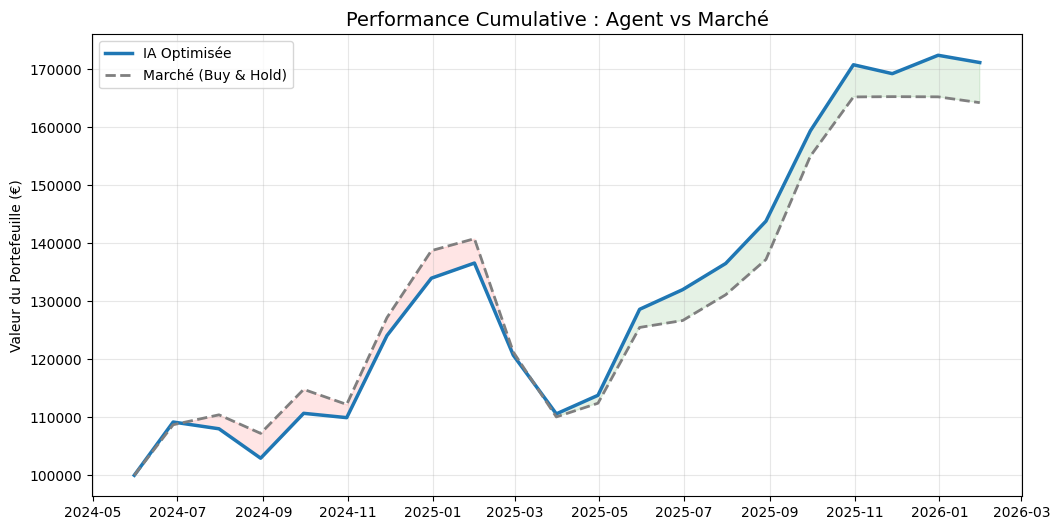

Rendement IA : 71.19%
Rendement Marché : 64.27%


In [13]:
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor

# ==========================================
# IV. EXECUTION
# ==========================================

# 1. Données
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA']
prices_raw = get_data(tickers, "15y")
prices_m, features_m = calculate_monthly_features(prices_raw)

# 2. Normalisation & Split
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features_m), index=features_m.index, columns=features_m.columns)

split_idx = len(features_scaled) - 24 # 2 ans de test
train_p, test_p = prices_m.iloc[:split_idx], prices_m.iloc[split_idx:]
train_f, test_f = features_scaled.iloc[:split_idx], features_scaled.iloc[split_idx:]

# 3. Entraînement
log_dir = "./logs/logs_trading_SAC/"
os.makedirs(log_dir, exist_ok=True)
env_train = MonthlyTradingEnv(train_p, train_f, lookback_window=3)
env_train = Monitor(env_train, log_dir)
model = SAC("MlpPolicy", env_train, verbose=1)
model.learn(total_timesteps=20000)

# 4. Évaluation finale
evaluate_and_save_plot(model, test_p, test_f, log_dir, lookback=3, initial_balance=100000)

# **5 - Cuckoo Search optimization for SAC**

In [17]:
import math

# ==========================================
# III. CUCKOO SEARCH OPTIMIZATION
# ==========================================

def levy_flight(Lambda):
    sigma = (math.gamma(1 + Lambda) * np.sin(np.pi * Lambda / 2) /
            (math.gamma((1 + Lambda) / 2) * Lambda * 2**((Lambda - 1) / 2)))**(1 / Lambda)
    u = np.random.normal(0, sigma, 1)
    v = np.random.normal(0, 1, 1)
    step = u / abs(v)**(1 / Lambda)
    return step

def objective_function(params, train_p, train_f):
    lr, gamma, batch_exp = params
    batch_size = int(2**round(batch_exp))
    try:
        env = MonthlyTradingEnv(train_p, train_f, lookback_window=3)
        model = SAC("MlpPolicy", env, learning_rate=lr, gamma=gamma,
                    batch_size=batch_size, verbose=0, learning_starts=10)
        model.learn(total_timesteps=10000)
        obs, _ = env.reset()
        done = False
        final_val = 100000
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, _, info = env.step(action)
            final_val = info['portfolio_value']
        return - (final_val / 100000 - 1)
    except:
        return 999

def cuckoo_search(n_nests, iterations, train_p, train_f):
    nests = np.random.uniform([1e-4, 0.8, 6], [1e-2, 0.99, 9], (n_nests, 3))
    fitness = np.array([objective_function(n, train_p, train_f) for n in nests])
    best_nest = nests[np.argmin(fitness)]
    for i in range(iterations):
        for j in range(n_nests):
            step = 0.01 * levy_flight(1.5) * (nests[j] - best_nest)
            new_nest = np.clip(nests[j] + step, [1e-4, 0.8, 6], [1e-2, 0.99, 9])
            new_fit = objective_function(new_nest, train_p, train_f)
            if new_fit < fitness[j]:
                fitness[j] = new_fit
                nests[j] = new_nest
        best_nest = nests[np.argmin(fitness)]
        print(f"CS Opti | Iter {i+1} | Meilleur rendement : {-np.min(fitness)*100:.2f}%")
    return best_nest

# **6 - SAC with hyperparameters optimization**

/tmp/ipython-input-2296746.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)['Close']
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[                       0%                       ]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*******************   40%                       ]  2 of 5 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: Dep


--- Lancement Cuckoo Search (SAC) ---
CS Opti | Iter 1 | Meilleur rendement : 2600397.93%
CS Opti | Iter 2 | Meilleur rendement : 2600397.93%
CS Opti | Iter 3 | Meilleur rendement : 2600397.93%

Entraînement final (LR: 0.00300, Gamma: 0.824, Batch: 512)
Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 142      |
|    ep_rew_mean     | 3.84     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 97       |
|    time_elapsed    | 5        |
|    total_timesteps | 568      |
| train/             |          |
|    actor_loss      | -3.64    |
|    critic_loss     | 0.00417  |
|    ent_coef        | 0.247    |
|    ent_coef_loss   | -11.8    |
|    learning_rate   | 0.003    |
|    n_updates       | 467      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 142      |
|    ep_rew_

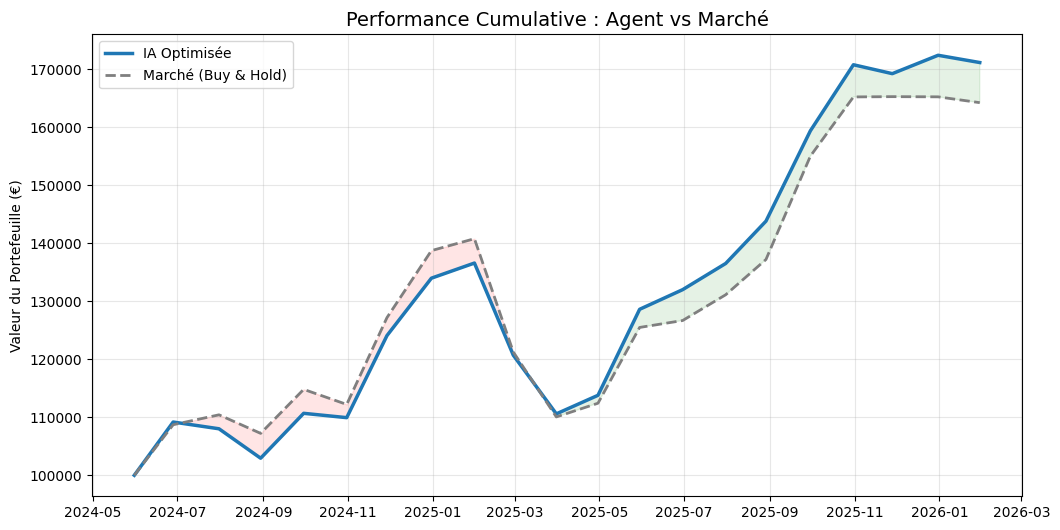

Rendement IA : 71.19%
Rendement Marché : 64.27%


In [23]:
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor

# ==========================================
#   EXECUTION
# ==========================================

# 1. Données
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA']
prices_raw = get_data(tickers, "15y")
prices_m, features_m = calculate_monthly_features(prices_raw)

# 2. Normalisation & Split
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features_m), index=features_m.index, columns=features_m.columns)

split_idx = len(features_scaled) - 24 # 2 ans de test
train_p, test_p = prices_m.iloc[:split_idx], prices_m.iloc[split_idx:]
train_f, test_f = features_scaled.iloc[:split_idx], features_scaled.iloc[split_idx:]

# 3. Optimisation
print("\n--- Lancement Cuckoo Search (SAC) ---")
best_hparams = cuckoo_search(5, 3, train_p, train_f)

# 4. Entraînement final
final_lr, final_gamma, final_batch_exp = best_hparams
final_batch = int(2**round(final_batch_exp))

print(f"\nEntraînement final (LR: {final_lr:.5f}, Gamma: {final_gamma:.3f}, Batch: {final_batch})")

log_dir = "./logs/logs_trading_CS_SAC/"
os.makedirs(log_dir, exist_ok=True)


env_train = MonthlyTradingEnv(train_p, train_f, lookback_window=3)
env_train = Monitor(env_train, log_dir)
model_final = SAC("MlpPolicy", env_train, learning_rate=final_lr,
                  gamma=final_gamma, batch_size=final_batch, verbose=1)
model_final.learn(total_timesteps=20000)

# 5. Évaluation
evaluate_and_save_plot(model, test_p, test_f, log_dir, lookback=3, initial_balance=100000)



# **7 - Cuckoo search optimization for PPO**

In [19]:
import math

# ==========================================
# III. CUCKOO SEARCH OPTIMIZATION
# ==========================================

def objective_function_ppo(params, train_p, train_f):
    lr, gamma, n_steps_exp, ent_coef = params
    n_steps = int(2**round(n_steps_exp))
    try:
        env = MonthlyTradingEnv(train_p, train_f, lookback_window=3)
        model = PPO("MlpPolicy", env, learning_rate=lr, gamma=gamma,
                    n_steps=n_steps, ent_coef=ent_coef, verbose=0)
        model.learn(total_timesteps=10000)
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, _, info = env.step(action)
        return - (info['portfolio_value'] / 100000 - 1)
    except:
        return 999

def cuckoo_search_ppo(n_nests, iterations, train_p, train_f):
    nests = np.random.uniform([1e-5, 0.8, 5, 0.0], [1e-3, 0.99, 10, 0.05], (n_nests, 4))
    fitness = np.array([objective_function_ppo(n, train_p, train_f) for n in nests])
    best_nest = nests[np.argmin(fitness)]
    for i in range(iterations):
        for j in range(n_nests):
            sigma = (math.gamma(1 + 1.5) * np.sin(np.pi * 1.5 / 2) / (math.gamma((1 + 1.5) / 2) * 1.5 * 2**((1.5 - 1) / 2)))**(1 / 1.5)
            step = 0.01 * (np.random.normal(0, sigma, 1) / abs(np.random.normal(0, 1, 1))**(1/1.5)) * (nests[j] - best_nest)
            new_nest = np.clip(nests[j] + step, [1e-5, 0.8, 5, 0.0], [1e-3, 0.99, 10, 0.05])
            new_fit = objective_function_ppo(new_nest, train_p, train_f)
            if new_fit < fitness[j]:
                fitness[j] = new_fit
                nests[j] = new_nest
        best_nest = nests[np.argmin(fitness)]
        print(f"PPO Opti | Iter {i+1} | Meilleur Rendement : {-np.min(fitness)*100:.2f}%")
    return best_nest

# **8 - PPO with hyperparameters optimization**

/tmp/ipython-input-2296746.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=period)['Close']
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[                       0%                       ]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*******************   40%                       ]  2 of 5 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: Dep


--- Lancement Cuckoo Search (SAC) ---


/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 32`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 32
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=32 and n_envs=1)
  warnings.warn(


PPO Opti | Iter 1 | Meilleur Rendement : 85511.87%
PPO Opti | Iter 2 | Meilleur Rendement : 103949.96%
PPO Opti | Iter 3 | Meilleur Rendement : 112818.93%

--- Phase 2: Entraînement Final PPO ---
Params: LR=0.000515, Gamma=0.9382, n_steps=256
Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 142      |
|    ep_rew_mean     | 3.92     |
| time/              |          |
|    fps             | 892      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 256      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 142         |
|    ep_rew_mean          | 3.48        |
| time/                   |             |
|    fps                  | 656         |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 

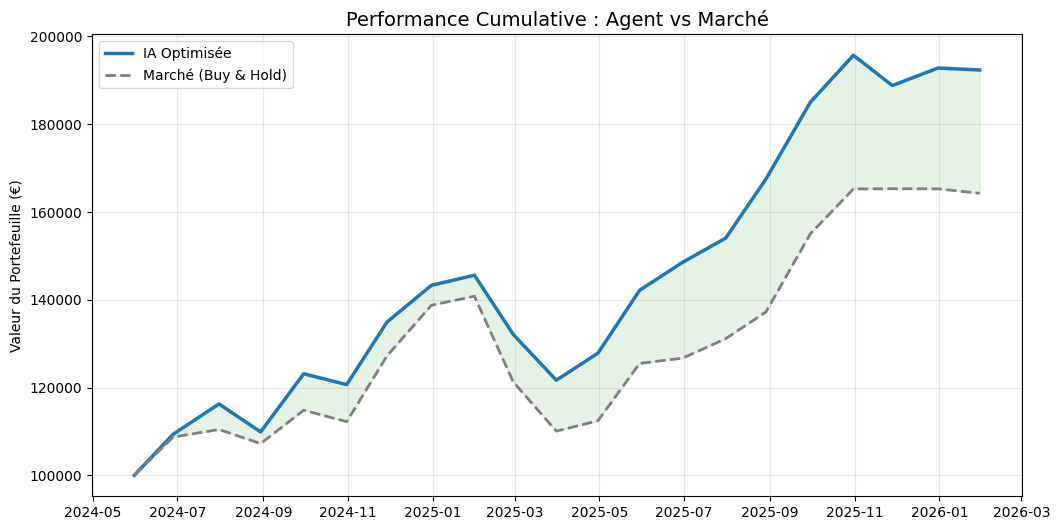

Rendement IA : 92.36%
Rendement Marché : 64.27%


In [22]:
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor

# ==========================================
#   EXECUTION
# ==========================================

# 1. Données
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'TSLA']
prices_raw = get_data(tickers, "15y")
prices_m, features_m = calculate_monthly_features(prices_raw)

# 2. Normalisation & Split
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features_m), index=features_m.index, columns=features_m.columns)

split_idx = len(features_scaled) - 24 # 2 ans de test
train_p, test_p = prices_m.iloc[:split_idx], prices_m.iloc[split_idx:]
train_f, test_f = features_scaled.iloc[:split_idx], features_scaled.iloc[split_idx:]

# 3. Optimisation
print("\n--- Lancement Cuckoo Search (SAC) ---")
best_p = cuckoo_search_ppo(5, 3, train_p, train_f)

# 4. Entraînement final
final_lr, final_gamma, final_n_steps_exp, final_ent = best_p
final_n_steps = int(2**round(final_n_steps_exp))

print(f"\n--- Phase 2: Entraînement Final PPO ---")
print(f"Params: LR={final_lr:.6f}, Gamma={final_gamma:.4f}, n_steps={final_n_steps}")

log_dir = "./logs/logs_trading_CS_PPO/"
os.makedirs(log_dir, exist_ok=True)

env_train = MonthlyTradingEnv(train_p, train_f, lookback_window=3)
env_train = Monitor(env_train, log_dir)
model_ppo = PPO("MlpPolicy", env_train, learning_rate=final_lr, gamma=final_gamma,
                n_steps=final_n_steps, ent_coef=final_ent, verbose=1)
model_ppo.learn(total_timesteps=20000)


# 5. Évaluation
evaluate_and_save_plot(model_ppo, test_p, test_f, log_dir, lookback=3, initial_balance=100000)

